## 전처리 노트북
이 노트북은 high-level topics(결혼연령, 주기적 운동강도, 흡연량 등 사람 행위에 관련된 피처) 데이터셋([A sample for public purpose](https://nih.go.kr/ko/main/contents.do?menuNo=300567))을 전처리하는 내용을 다룬다.

## 선언

In [39]:
import os
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.font_manager import fontManager, FontProperties

fontPath="https://raw.githubusercontent.com/orioncactus/pretendard/main/packages/pretendard/dist/public/static/alternative/Pretendard-Regular.ttf"
fontFile=Path("./res/Pretendard.ttf")

if not os.path.exists(fontFile):
  res=requests.get(fontPath)
  fontFile.write_bytes(res.content)

fontManager.addfont(fontFile)
fontProperty=FontProperties(fname=fontFile)
sns.set(font=fontProperty.get_name())

padding="ㅡ"*10
res="./res"

_spec_type_dict={
    "연속형":"contiguous",
    "범주형":"sparse",
    "날짜":"date",
    "ID":"idx",
    "#":None
}

_spec_column_list=[
    "seq",
    "table",
    "table_",
    "variable",
    "variableInfo",
    "variableValue",
    "variableType",
    "variableView"
]

_uk_dict={
    66666:np.nan,
    77777:np.nan,
    99999:np.nan
}

_indices=["id","date","visit","data_class"]

_feather_write_option=dict(
  compression="zstd",
  compression_level=9
)


## 데이터셋 코드북 전처리
데이터셋의 컬럼 설명을 코드북이라고 부르고 있다. 이 코드북에서는 table_이 프론트엔드의 페이지나 hr로 나뉠 수 있는 단위가 되고, variableView 등이 label이 될 수 있다.

In [40]:
if not os.path.exists(os.path.join(res,"koges-spec.feather")):
    _spec=[q.path for q in os.scandir(res) if q.name.endswith(".xlsx")]
    koges_spec=pd.concat([pd.read_excel(q,skiprows=2).set_axis(_spec_column_list,axis=1) for q in _spec],axis=0).drop("seq",axis=1)
    koges_spec=koges_spec.applymap(
        lambda q:"#" if pd.isna(q) else q
    )
    koges_spec.loc[:,"variable"]=koges_spec.variable.map(
        lambda q:q[q.find("_")+1:].strip().lower()
    )
    koges_spec.loc[:,"variableInfo"]=koges_spec.variableInfo.map(
        lambda q:q.replace("\n","_").strip()
    )
    koges_spec.loc[:,"variableType"]=list(map(
        lambda q:_spec_type_dict[q],koges_spec.variableType
    ))
    koges_spec.loc[:,"variableInfo"]=koges_spec.variableInfo.apply(
        lambda q:q.replace("_",": ").replace("- ",": ").replace(": : ",": ").strip()
    )

    def koges_spec_variableValue_sanitise(x:str):
        '''An adhoc function to removing lineseps'''
        x=x.strip()
        if x.startswith("\n"):
            x=x[2:]
        if x.endswith("\n"):
            x=x[:-3]
        if x.__contains__("\n"):
            x=x.replace("\n",", ")
        return x
    
    koges_spec.loc[:,"variableValue"]=koges_spec.variableValue.map(
        koges_spec_variableValue_sanitise
    )
    koges_spec.index=range(koges_spec.shape[0])
    koges_spec.to_feather(os.path.join(res,"koges-spec.feather"),**_feather_write_option)

else:
    print(padding,"Found a sanitised spec file")
    koges_spec=pd.read_feather(os.path.join(res,"koges-spec.feather"))

koges_spec[koges_spec.variableType=="sparse"].sample(5)

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ Found a sanitised spec file


,table,table_,variable,variableInfo,variableValue,variableType,variableView
8,FOLLOW_03_DATA,생활습관,ricefq,정종 음주빈도,"0=없다, 1=월1회, 2=월 2-3회, 3=주 1회, 4=주2-3회, 5=주4-6...",sparse,\n 2-a) 정종을 1년 동안 드신 평균횟수는?\n ...
123,BASE_DATA2,가족력,fmfht1,고혈압 진단여부(부),"1=아니오, 2=예",sparse,\n■ 가족력에 관한 문항입니다. 본가 식구들을 기준으로 기입해 주세요(여성의 경우...
125,BASE_DATA2,가족력,fmfdm1,당뇨병 진단여부(부),"1=아니오, 2=예",sparse,\n ▶ 당뇨병 진단 여부(부)\n ① 아니오\n ...
16,FOLLOW_03_DATA,생활습관,hliqfq,양주 음주빈도,"0=없다, 1=월1회, 2=월 2-3회, 3=주 1회, 4=주2-3회, 5=주4-6...",sparse,\n 6-a) 양주를 1년 동안 드신 평균횟수는?\n ...
185,FOLLOW_05_DATA,생활습관,hliqfq,양주 음주빈도,"0=없다, 1=월1회, 2=월 2-3회, 3=주 1회, 4=주2-3회, 5=주4-6...",sparse,\n 6-a) 양주를 1년 동안 드신 평균횟수는?\n ...


## 쪼개진 데이터셋 결합 및 정리
쪼개진 롱기튜디널 데이터는 결합하고, SQL이나 SAS 스타일 컬럼 이름을 바꾼다.

In [41]:
_data={q.name.split(".")[0]:pd.read_csv(q.path) for q in os.scandir(res) if q.name.lower().startswith("follow")}
for d in _data:
    _data[d]=_data[d].set_axis([q[q.index("_")+1:].lower() for q in _data[d].columns],axis=1).rename(columns={"edate":"date"}).assign(visit=d)
    _data[d].loc[:,"id"]=_data[d].id.map(lambda q:str(q[q.rfind("_")+1:]))
koges=pd.concat(_data.values()).convert_dtypes().set_index(_indices).sort_index()
koges.iloc[:5]

sex  age   edu  marry  drink  drdu  \
id   date   visit          data_class                                        
0001 200412 FOLLOW_01_DATA F05            1   56     1      2      3     4   
     200909 FOLLOW_03_DATA F05         <NA>   61  <NA>      2      2  <NA>   
     201208 FOLLOW_04_DATA F05         <NA>   64  <NA>      2      2  <NA>   
0002 200401 FOLLOW_01_DATA F19            1   40     3      2      3     4   
     200810 FOLLOW_03_DATA F19         <NA>   44  <NA>      2      3  <NA>   

                                       takfq    takam  ricefq   riceam  ...  \
id   date   visit          data_class                                   ...   
0001 200412 FOLLOW_01_DATA F05             0  77777.0       0  77777.0  ...   
     200909 FOLLOW_03_DATA F05             0  77777.0       0  77777.0  ...   
     201208 FOLLOW_04_DATA F05             0  77777.0       0  77777.0  ...   
0002 200401 FOLLOW_01_DATA F19             0  77777.0       0  77777.0  ...   
     200810 FOLLOW_03_DATA F19             0  77777.0       0  77777.0  ...   

                                       dbp  hba1c   glu0  creatinine  ast  \
id   date   visit          data_class                                       
0001 200412 FOLLOW_01_DATA F05          80    5.6     82         0.7   30   
     200909 FOLLOW_03_DATA F05          69    5.8     96         0.9   18   
     201208 FOLLOW_04_DATA F05          70    5.9     92         1.1   24   
0002 200401 FOLLOW_01_DATA F19         118    5.5    130         1.1   46   
     200810 FOLLOW_03_DATA F19          82    5.5  99999         1.0   31   

                                       alt  tchl  hdl   tg     ins0  
id   date   visit          data_class                                
0001 200412 FOLLOW_01_DATA F05          38   154   35  126      6.7  
     200909 FOLLOW_03_DATA F05          14   190   35  111     12.0  
     201208 FOLLOW_04_DATA F05          29   179   28  139      6.5  
0002 200401 FOLLOW_01_DATA F19          75   214   44  169      4.3  
     200810 FOLLOW_03_DATA F19          33   147   39  320  99999.0  

[5 rows x 61 columns]

## 데이터셋 살펴보기

In [42]:
koges_agg=koges.select_dtypes("number").agg(["mean","median","max","min",lambda q:q.isna().sum(),"count"]).T
koges_agg.sample(5)

,mean,median,max,min,<lambda>,count
fmfdm,1.011220,1.0,2.0,1.0,0.0,2852.0
smag,51251.670000,77777.0,99999.0,12.0,1852.0,1000.0
drink,422.706522,2.0,99999.0,1.0,0.0,2852.0
marry,317.698107,2.0,99999.0,1.0,0.0,2852.0
ast,96.732118,25.0,99999.0,11.0,0.0,2852.0


In [43]:
koges_agg.loc[koges_agg["<lambda>"]>0]

,mean,median,max,min,<lambda>,count
sex,1.558,2.0,2.0,1.0,1852.0,1000.0
edu,702.283,2.0,99999.0,1.0,1852.0,1000.0
drdu,41478.984,77777.0,99999.0,1.0,1852.0,1000.0
smag,51251.670,77777.0,99999.0,12.0,1852.0,1000.0
mnsag,34886.254,18.0,99999.0,11.0,1852.0,1000.0
preg,34478.539,2.0,99999.0,1.0,1852.0,1000.0
fpregag,35312.563,28.0,99999.0,16.0,1852.0,1000.0
child,35100.519,2.0,99999.0,1.0,1852.0,1000.0
flabag,35546.167,29.0,99999.0,17.0,1852.0,1000.0


In [44]:
column_info=dict([q for q in koges_spec.loc[:,["variable","variableInfo"]].itertuples(index=False)])

In [45]:
def explain(column_list:list)->list:
  return list(map(lambda q:column_info[q] if q in column_info else q,column_list))

## 포워드 필링이 되는 컬럼 찾기
위의 NA에 대해, id 컬럼으로 groupbying하고 sorting하여 첫번째 row에서 baseline attributes (e.g. 초연연령, 성별)을 얻어 채울 컬럼을 본다.

In [46]:
fflo=koges.reset_index().groupby("id")
fflo=fflo.nth(0).notna().all() & fflo.nth(1).isna().any()
fflo_column=fflo[fflo].index.tolist()

In [47]:
dict(zip(
  fflo_column,
  explain(fflo_column)
))

{'sex': '성별',
 'edu': 'edu',
 'drdu': '지금까지 총 음주기간',
 'smag': 'smag',
 'mnsag': '초경나이',
 'preg': '임신 경험 여부',
 'fpregag': '첫 임신시 나이',
 'child': 'child',
 'flabag': 'flabag'}

In [48]:
koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill().iloc[:6]

sex  edu  drdu  smag  mnsag   preg  \
id   date   visit          data_class                                       
0001 200412 FOLLOW_01_DATA F05           1    1     4    20  77777  77777   
     200909 FOLLOW_03_DATA F05           1    1     4    20  77777  77777   
     201208 FOLLOW_04_DATA F05           1    1     4    20  77777  77777   
0002 200401 FOLLOW_01_DATA F19           1    3     4    20  77777  77777   
     200810 FOLLOW_03_DATA F19           1    3     4    20  77777  77777   
     201110 FOLLOW_04_DATA F19           1    3     4    20  77777  77777   

                                       fpregag  child  flabag  
id   date   visit          data_class                          
0001 200412 FOLLOW_01_DATA F05           77777  77777   77777  
     200909 FOLLOW_03_DATA F05           77777  77777   77777  
     201208 FOLLOW_04_DATA F05           77777  77777   77777  
0002 200401 FOLLOW_01_DATA F19           77777  77777   77777  
     200810 FOLLOW_03_DATA F19           77777  77777   77777  
     201110 FOLLOW_04_DATA F19           77777  77777   77777

In [49]:
koges.loc[:,fflo_column]=koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill()

/tmp/ipykernel_106551/4241712286.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  koges.loc[:,fflo_column]=koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill()
/tmp/ipykernel_106551/4241712286.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  koges.loc[:,fflo_column]=koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill()
/tmp/ipykernel_106551/4241712286.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain th

In [50]:
if len(koges.columns.tolist()) == len(set(koges.columns.tolist())):print(padding)

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


## 최근 획득값으로 채우기(베이스라인 값으로 채우기)
Female-only columns의 smag는 초연연령으로 생각된다.

In [51]:
feamle_only_column=fflo_column[3:]
koges.groupby("sex")[feamle_only_column].value_counts()

sex  smag   mnsag  preg   fpregag  child  flabag
1    77777  77777  77777  77777    77777  77777     233
     20     77777  77777  77777    77777  77777     232
     19     77777  77777  77777    77777  77777     122
     18     77777  77777  77777    77777  77777      96
     21     77777  77777  77777    77777  77777      84
                                                   ... 
2    77777  18     2      26       2      27          2
            20     2      23       1      23          2
                          25       2      26          2
            15     2      27       2      27          2
            14     2      29       2      30          2
Length: 361, dtype: int64

In [52]:
koges.loc[koges.sex<2,
  [q for q in feamle_only_column if q.endswith("ag")]
]=100
koges.loc[koges.sex<2,
  [q for q in feamle_only_column if not q.endswith("ag")]
]=-1

In [53]:
koges.groupby("sex")[feamle_only_column].value_counts()

sex  smag   mnsag  preg  fpregag  child  flabag
1    100    100    -1    100      -1     100       1266
2    77777  17     2     23       2      23          20
            16     2     24       2      25          20
            14     2     23       2      24          20
            15     2     21       1      22          18
                                                   ... 
                         18       1      19           2
            16     2     23       1      23           2
                         31       2      32           2
            17     2     26       1      27           2
                         18       1      18           2
Length: 331, dtype: int64

## 방문일 스케일링

In [54]:
_date=np.asarray([f"{str(q)[:4]}-{str(q)[-2:]}" for q in koges.index.get_level_values(1).unique()],dtype="M")
_date_min=np.min(_date)
_date_max=np.max(_date)
_date_difference=np.abs(_date_min-_date_max)

_scale_date=lambda q:(q-_date_min)/_date_difference
_parse_date=lambda q:f"{str(q)[:4]}-{str(q)[-2:]}"

In [55]:
_date_scale_dict=dict(zip(
  _date.astype(dtype=str),
  np.asarray([_scale_date(q) for q in _date],dtype=np.float32)
))

_date_scale_dict

{'2004-12': 0.16197184,
 '2009-09': 0.5633803,
 '2012-08': 0.80985916,
 '2004-01': 0.08450704,
 '2008-10': 0.48591548,
 '2011-10': 0.7394366,
 '2003-09': 0.056338027,
 '2008-06': 0.45774648,
 '2011-06': 0.7112676,
 '2005-04': 0.19014084,
 '2010-05': 0.6197183,
 '2013-04': 0.86619717,
 '2004-02': 0.09154929,
 '2009-01': 0.5070422,
 '2011-11': 0.74647886,
 '2012-10': 0.8239437,
 '2004-10': 0.14788732,
 '2012-11': 0.8309859,
 '2003-08': 0.049295776,
 '2009-07': 0.5492958,
 '2012-07': 0.8028169,
 '2003-01': 0.0,
 '2007-10': 0.40140846,
 '2011-08': 0.7253521,
 '2003-12': 0.07746479,
 '2008-04': 0.44366196,
 '2012-09': 0.8169014,
 '2003-02': 0.0070422534,
 '2008-08': 0.471831,
 '2005-02': 0.17605634,
 '2010-08': 0.64084506,
 '2005-12': 0.24647887,
 '2010-09': 0.64788735,
 '2013-08': 0.8943662,
 '2004-08': 0.13380282,
 '2008-05': 0.45070422,
 '2011-04': 0.6971831,
 '2004-11': 0.15492958,
 '2012-06': 0.79577464,
 '2012-12': 0.8380282,
 '2009-10': 0.57042253,
 '2013-07': 0.8873239,
 '2005-01': 

In [56]:
koges=koges.assign(theta=list(map(
  lambda q:_date_scale_dict[_parse_date(q)],koges.index.get_level_values(1)
)))
koges.sample(3)

,,,,sex,age,edu,marry,drink,drdu,takfq,takam,ricefq,riceam,...,hba1c,glu0,creatinine,ast,alt,tchl,hdl,tg,ins0,theta
id,date,visit,data_class,,,,,,,,,,,,,,,,,,,,,
0527,200907,FOLLOW_03_DATA,F16,2,73,1,3,1,77777,0,77777.0,0,77777.0,...,66666.0,82,0.9,20,26,180,44,231,66666.0,0.549296
0998,201111,FOLLOW_04_DATA,F19,1,49,5,2,3,4,0,77777.0,0,77777.0,...,5.3,91,0.9,33,22,240,41,217,7.9,0.746479
0080,200508,FOLLOW_01_DATA,F01,1,54,1,2,1,77777,0,77777.0,0,77777.0,...,66666.0,91,1.2,28,21,183,27,262,6.4,0.218310


## Impute Contiguous Variables

In [57]:
def varSelectorType(variableType:str)->list:
  final=[q for q in np.unique(
    koges_spec.loc[koges_spec.variableType==variableType,"variable"].values
    ) if q in koges.columns and q!="DATA_CLASS"
  ]
  return final


In [58]:
gaseol="dbp"
eg="sbp"

In [59]:
koges_impute=koges.applymap(lambda q:_uk_dict[q] if q in _uk_dict else q)
koges_impute=koges_impute.loc[pd.notna(koges_impute[gaseol]),:]

In [60]:
x0_impute=koges_impute[[q for q in koges_impute.columns if not q==gaseol]]
y0_impute=koges_impute[gaseol]
print(f"{y0_impute.name}")

dbp


<Axes: xlabel='sbp', ylabel='Count'>

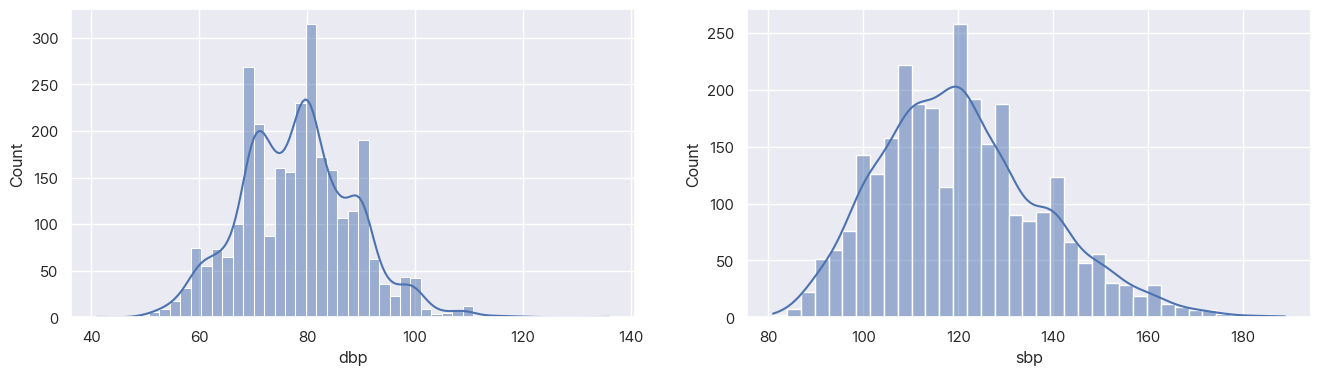

In [61]:
_,ax=plt.subplots(1,2,figsize=(16,4))
sns.histplot(y0_impute,ax=ax[0],kde=True,legend=False)
sns.histplot(x0_impute[eg],ax=ax[1],kde=True,legend=False)

In [82]:
x0y0_impute=pd.concat([x0_impute,y0_impute],axis=1)
x0y0_impute.reset_index().to_feather("./res/x0y0-impute.feather")
print(f"{x0y0_impute.shape=}")

x0y0_impute.shape=(2850, 62)


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import PowerTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

split=10**1
Splitter=ShuffleSplit(n_splits=split,random_state=23301522)

Mutater=PowerTransformer()
Estimator=RandomForestRegressor(
  random_state=23301522,
  max_features="sqrt",
  min_samples_split=int(len(set(koges.index.get_level_values(0)))*.5)
)

def make_tester_of(Imputer):
  return Pipeline(
    steps=[
      ("Yj",Mutater),
      ("An imputer",Imputer),
      ("Nan-resist regressor",Estimator)
    ],
    verbose=False
  )

def score_of(
  Tester:Pipeline,
  x,y
):
  print(Tester)
  return cross_val_score(
    Tester,
    x,y,
    scoring="neg_mean_absolute_error",
    cv=Splitter
  )


In [66]:
score_org=score_of(
  make_tester_of(SimpleImputer(strategy="constant")),x0_impute,y0_impute)
score_mean=score_of(
  make_tester_of(SimpleImputer(strategy="mean")),x0_impute,y0_impute)
score_near=score_of(
  make_tester_of(KNNImputer(add_indicator=False)),x0_impute,y0_impute)
score_mice=score_of(
  make_tester_of(IterativeImputer(
    min_value=0,
    sample_posterior=True,
    max_iter=10**2,
    tol=1e-3
  )),x0_impute,y0_impute)

result_imputed=dict(zip(
  ("Org","Mean","Near","Mice"),
  [q for q in (score_org,score_mean,score_near,score_mice)]
))

Pipeline(steps=[('Yj', PowerTransformer()),
                ('An imputer', SimpleImputer(strategy='constant')),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])
Pipeline(steps=[('Yj', PowerTransformer()), ('An imputer', SimpleImputer()),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])
Pipeline(steps=[('Yj', PowerTransformer()), ('An imputer', KNNImputer()),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])
Pipeline(steps=[('Yj', PowerTransformer()),
         

(-7.6, -7.9)

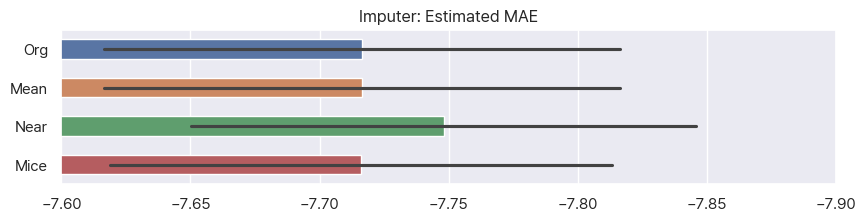

In [67]:
_,ax=plt.subplots(figsize=(10,2))
sns.barplot(result_imputed,errorbar="se",width=.5,orient="y").set_title("Imputer: Estimated MAE")
ax.set_xlim(-7.6,-7.9)

In [68]:
import cupy as cp
import cuml

from cuml.preprocessing import PolynomialFeatures
from cuml import IncrementalPCA

from sklearn.cluster import AgglomerativeClustering
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score

from time import time

cuml.set_global_output_type="numpy"

degree=3
Polynomials=PolynomialFeatures(degree)

Imputer=IterativeImputer(
  min_value=0,
  sample_posterior=True,
  max_iter=10**2,
  tol=1e-3
)

def get_cluster_preprocessor():
  return Pipeline(
  steps=[
    ("Yj",Mutater),
    ("Imputer",Imputer),
    ("Polynomials",Polynomials)
  ]
)

def cluster(X,cluster_count_range=(2,12)):
  cluster_count_range:range=range(cluster_count_range[0],cluster_count_range[1]+1)
  cluster:dict={}

  for cluster_count in cluster_count_range:
    t0=time()

    Clusterer=AgglomerativeClustering(
      n_clusters=cluster_count,
      linkage="ward"
    )

    Xt=get_cluster_preprocessor().fit_transform(X)

    Clusterer.fit(Xt)

    cluster[cluster_count]=(cython_silhouette_score(
        X=cp.asarray(Xt,dtype=cp.float32),
        labels=cp.asarray(Clusterer.labels_),
        chunksize=10**4, # Chunk causes divided by zero error
      ),
      Clusterer
    )

    print(f"Clustering {Xt.shape} ({Xt.nbytes/1024**2:2f}MiB), took {time()-t0:.2f}s")

  fig,ax=plt.subplots(figsize=(4,4))
  ax.plot(cluster_count_range,[q[0] for q in cluster.values()])
  ax.set_xlabel("n")
  ax.set_ylabel("score")
  ax.set_title("Silhouette Score by Number of Cluster")

  return cluster,fig,ax


Clustering (2850, 43680) (949.768066MiB), took 146.87s
Clustering (2850, 43680) (949.768066MiB), took 147.80s
Clustering (2850, 43680) (949.768066MiB), took 147.56s
Clustering (2850, 43680) (949.768066MiB), took 146.91s
Clustering (2850, 43680) (949.768066MiB), took 146.42s
Clustering (2850, 43680) (949.768066MiB), took 146.78s
Clustering (2850, 43680) (949.768066MiB), took 147.06s
Clustering (2850, 43680) (949.768066MiB), took 146.58s
Clustering (2850, 43680) (949.768066MiB), took 147.35s
Clustering (2850, 43680) (949.768066MiB), took 146.44s
Clustering (2850, 43680) (949.768066MiB), took 146.41s


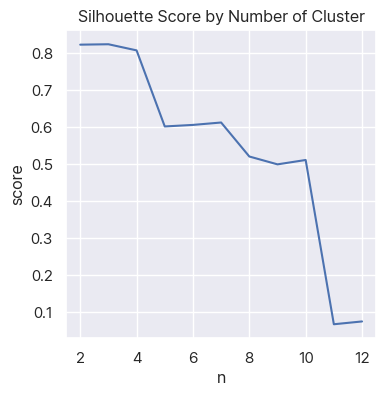

In [69]:
result_cluster=cluster(
  pd.concat([x0_impute,y0_impute],axis=1).reset_index(drop=True)
)

In [70]:
Mutater=PowerTransformer()
Reducer=IncrementalPCA(n_components=2,batch_size=250,output_type="numpy") # 100 * 1050MB

polynomial_reducer_processor=Pipeline([
  ("yj",Mutater),
  ("mi",Imputer),
  ("vmm",Polynomials),
  ("reducer",Reducer)
],verbose=True)

result_polynomial_reduced=polynomial_reducer_processor.fit_transform(pd.concat([x0_impute,y0_impute],axis=1))


[Pipeline] ................ (step 1 of 4) Processing yj, total=   0.2s
[Pipeline] ................ (step 2 of 4) Processing mi, total=  59.1s
[Pipeline] ............... (step 3 of 4) Processing vmm, total=   0.3s
[Pipeline] ........... (step 4 of 4) Processing reducer, total=   7.4s


In [73]:
cluster_for_plot=result_cluster[0][5][1].labels_
{q:(cluster_for_plot==q).sum() for q in np.unique(cluster_for_plot)}

{0: 2756, 1: 22, 2: 1, 3: 8, 4: 63}

(-134.19226418502905, 1874.985734603668, -4523.88595958224, 441.7501655327779)

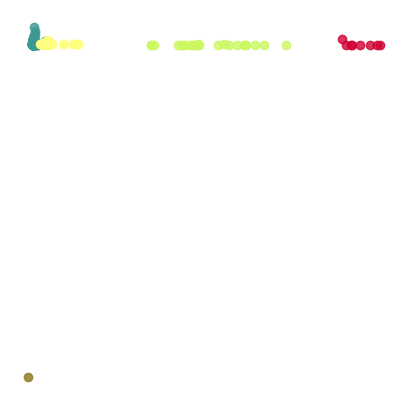

In [75]:
sek=["xkcd:"+q for q in [
  "sea","pear","hazel","cherry","banana",
  "caramel","canary","clay","grape","iris",
  "ice","lemon"
]]

trimmer=np.abs(result_polynomial_reduced.sum(axis=1))<=5000
reduce_result_=result_polynomial_reduced[trimmer]

plt.subplots(figsize=(5,5))
for sek_,code_ in zip(sek,np.unique(cluster_for_plot)):
  plt.scatter(
    reduce_result_[cluster_for_plot[trimmer]==code_,0],
    reduce_result_[cluster_for_plot[trimmer]==code_,1],
    color=sek_,
    label=str(code_),
    alpha=.8
  )
plt.axis("off")

In [76]:
import cupy as cp

vram=(cp.get_default_memory_pool(),cp.get_default_pinned_memory_pool())

def _freeVram(vram):
  for mp in vram:
    mp.free_all_blocks()
  return 

def meanSquaredError(prediction,answer)->cp.ndarray:
  s=cp.average(
    cp.average((prediction-answer)**2,axis=0)
  )
  return s

def crossValidate(
  estimator,
  i,
  o,
  splitter,
  scorer,
):
  _splits=splitter.split(i,o)
  
  _rslt=[]
  for train_idx,test_idx in _splits:
    coef=estimator(
      i[train_idx],
      o[train_idx]
    )
    prediction=cp.dot(
      cp.asarray(i[test_idx],dtype=cp.float32),
      coef
    )
    score=scorer(
      prediction,
      cp.asarray(o[test_idx],dtype=cp.float32)
    )

    _rslt.append([cp.asnumpy(coef),cp.asnumpy(score)])
  
  estimator,
  scorer,
  i,
  o,
  coef,
  prediction,
  score=(
    None,None,None,None,None,None,None
  )
  _freeVram(vram)

  return _rslt

def squareLeast(x,y,rcond=None)->cp.ndarray:
  if x.shape[0]==y.shape[0]:
    x=cp.asarray(x,dtype=cp.float32)
    y=cp.asarray(y,dtype=cp.float32)
    coef=cp.linalg.lstsq(x,y)
    
    x,y=(None,None)
    _freeVram(vram)

    return coef[0]
  raise IndexError("Row Count Mismatch")


In [79]:
result_cp_lm=crossValidate(
  squareLeast,
  cp.asarray(x0_impute.reset_index(drop=True),dtype=cp.float32),
  cp.asarray(y0_impute.reset_index(drop=True),dtype=cp.float32),
  splitter=Splitter,
  scorer=meanSquaredError
)

Inputs: (61,), 0 MiB


/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/cupy/linalg/_solve.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  warnings.warn(


In [73]:
polynomialCoefs=np.asarray([q[0] for q in r],np.float32)
polynomialStds=np.std(np.stack([r[0] for r in r]),axis=0)
polynomialCoefMeans=np.asarray(np.mean(polynomialCoefs,axis=0),np.float32)
polynomialCoefCi=[q[0]+q[1]*2 for q in zip(polynomialCoefMeans,polynomialStds)]
polynomialNames=[q.replace(" "," * ") for q in Polynomials.get_feature_names_out(xy.iloc[:,:-1].columns)]

made=50
components=[(p[0],p[1],p[2]) for p in 
  zip(polynomialNames,polynomialCoefMeans,polynomialCoefCi)]
components=sorted(components,key=lambda q:np.abs(q[1]),reverse=True)
components=components[:made]

sek="xkcd:blood red"

fig,ax=plt.subplots(figsize=(40,10))
sns.barplot(
  dict(zip(
    [q[0] for q in components],
    [q[1] for q in components])
  ),
  ax=ax,
  color=sek,
)
plt.errorbar(
  x=range(0,made),
  y=[q[1] for q in components],
  yerr=[np.abs(q[2]) for q in components],
  fmt="none",
  c=sek
)
plt.hlines(0,0,made,colors="gray",linestyle="dashed")
plt.grid(True,"both","y")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
ax.margins(x=0,y=.01)


In [80]:
# Cupy Lasso

from sklearn.model_selection import cross_validate

regressor_baseline_pipeline=Pipeline(
  [
    ("Mutater",PowerTransformer()),
    ("Imputer",Imputer),
    ("Expansion",PolynomialFeatures(degree)),
    ("Regressor",cuml.LinearRegression())
  ]
)

regressor_baseline=cross_validate(
  regressor_baseline_pipeline,
  x0_impute,
  y0_impute,
  scoring="neg_mean_absolute_error",
  cv=Splitter,
  return_estimator=True
)

/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


In [81]:
regressor_baseline

{'fit_time': array([157.48546147, 157.36746264, 156.67106676, 156.8463161 ,
        156.50268555, 156.16553044, 156.2615881 , 156.51685095,
        156.43351579, 156.72109628]),
 'score_time': array([4.52498055, 3.66363382, 3.02914548, 2.99776387, 3.44246268,
        3.71991825, 3.8858881 , 4.31152678, 3.80141592, 3.92797828]),
 'estimator': [Pipeline(steps=[('Mutater', PowerTransformer()),
                  ('Imputer',
                   IterativeImputer(max_iter=100, min_value=0,
                                    sample_posterior=True)),
                  ('Expansion', PolynomialFeatures()),
                  ('Regressor', LinearRegression())]),
  Pipeline(steps=[('Mutater', PowerTransformer()),
                  ('Imputer',
                   IterativeImputer(max_iter=100, min_value=0,
                                    sample_posterior=True)),
                  ('Expansion', PolynomialFeatures()),
                  ('Regressor', LinearRegression())]),
  Pipeline(steps=[('Mutater

In [66]:
# Cuml Lasso

from cuml.linear_model import Lasso
from sklearn.model_selection import cross_validate

alpha=np.logspace(-5,0,10**3,dtype=np.float32)

resultPerAlpha:dict={
  "alpha":[],"mse":[],"coef":[],"coefMean":[],
}

for _a in alpha:
  _crosser=cross_validate(
    Lasso(
      alpha=_a,
      fit_intercept=False,
      max_iter=10**2,
    ),
    x_ii_polynomials,
    y_ii,
    scoring="neg_mean_squared_error",
    return_estimator=True,
    verbose=4
  )

  _coef=cp.asarray(
    [c.coef_ for c in _crosser["estimator"]],
    cp.float32
  )
  _coefMean=cp.mean(_coef,axis=0)
  _mse=(cp.mean(cp.asarray(_crosser["test_score"],cp.float32))*-1)
  
  resultPerAlpha["alpha"].append(_a)
  resultPerAlpha["coef"].append(_coef.get())
  resultPerAlpha["coefMean"].append(_coefMean.get())
  resultPerAlpha["mse"].append(_mse.get())
  
  _crosser,_coef,_coefMean,_mse=(None,None,None,None)
  _freeVram(vram)


[CV] END ......................................, score=-4.429 total time=  13.4s
[CV] END ......................................, score=-4.593 total time=  13.8s
[CV] END ......................................, score=-4.091 total time=  13.6s
[CV] END ......................................, score=-3.275 total time=  13.7s
[CV] END ....................................., score=-28.402 total time=  13.1s
[CV] END ......................................, score=-4.396 total time=  13.1s
[CV] END ......................................, score=-4.514 total time=  13.2s
[CV] END ......................................, score=-4.084 total time=  13.1s
[CV] END ......................................, score=-3.278 total time=  13.1s
[CV] END ....................................., score=-18.852 total time=  13.0s
[CV] END ......................................, score=-4.364 total time=  13.2s
[CV] END ......................................, score=-4.451 total time=  13.5s
[CV] END ...................

KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

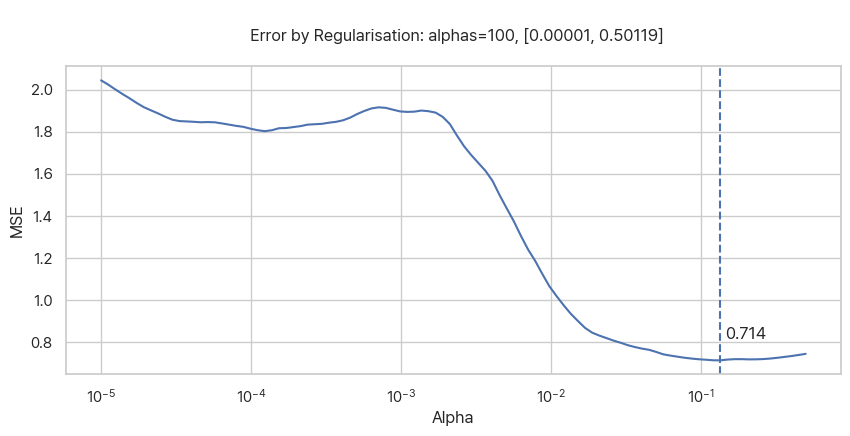

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))

ax.set_title(f"""
  MSE by Regularisation: alphas={len(alpha)}, [{alpha[0]:.5f}, {alpha[-1]:.5f}]
""")

plt.plot(resultPerAlpha["alpha"],resultPerAlpha["mse"])

alphaMin=np.min(resultPerAlpha["mse"])
alphaAtLowestMse=resultPerAlpha["alpha"][np.argmin(resultPerAlpha["mse"])]

plt.axvline(alphaAtLowestMse,linestyle="dashed")
plt.annotate(f"{alphaMin:.3f}",(alphaAtLowestMse+.01,alphaMin+.1))

ax.set_xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MSE")